In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import bernoulli
from IO.config import parse_config
from core import signal_generator
from core.freq_transform import transform_all

In [4]:
usr_config = parse_config('../yaml/example.yaml')

In [ ]:
N = 16
L = 20
phi = np.pi/2

usr_config.signal.block_size = N
usr_config.signal.num_blocks_avg = L
usr_config.signal.hop_size = N*L
usr_config.signal.num_pos_decision = 2

usr_config.noise.init_args.top = 0
usr_config.noise.init_args.steady_state = 0
npos = usr_config.signal.num_pos_decision
fs = usr_config.signal.fs

test_k = np.linspace(0,N,4001)
test_f = test_k/N * fs

ret = np.zeros((5,N,4001))

for idx_f, f in enumerate(test_f):
    #np.random.seed(55635)
    for idx_m, method in enumerate(['fft','fht','fht_jitter','fht_ditter','fht_jitter_filter']):
        usr_config.freq_transform_method.name = method
        usr_config.signal.phases = [phi]
        usr_config.signal.freqs = [f]

        input_signal_generator = signal_generator.InputSignalGenerator(usr_config.signal, usr_config.noise)
        input_signal, _ = input_signal_generator.get()
        input_signal = input_signal[:npos:,:,:]
        sqm, _ = transform_all(input_signal, usr_config.freq_transform_method, usr_config.signal)
        sqm = sqm.mean(1)
    
        ret[idx_m, :, idx_f] = sqm[0]

In [ ]:
bins = np.array([i for i in range(0,int(N/2))] + [i for i in range(int(N/2)+1, N)])
for k in bins:
    plt.figure(figsize=(10,5))
    #plt.plot(test_f[0:int(len(test_f)/2)],ret[0, k, 0:int(len(test_f)/2)],label='DFT',)
    #plt.plot(test_f[0:int(len(test_f)/2)],ret[2, k, 0:int(len(test_f)/2)],label='J-DHT')
    plt.plot(np.linspace(0,np.pi,int(len(test_f)/2)),ret[0, k, 0:int(len(test_f)/2)],label='DFT',linewidth=2)
    #plt.plot(np.linspace(0,np.pi,int(len(test_f)/2)),ret[2, k, 0:int(len(test_f)/2)],label='J-DHT',linewidth=2)
    plt.plot(np.linspace(0,np.pi,int(len(test_f)/2)),ret[1, k, 0:int(len(test_f)/2)],label='DHT',linewidth=2)
    plt.plot(np.linspace(0,np.pi,int(len(test_f)/2)),ret[3, k, 0:int(len(test_f)/2)],label='D-DHT',c='indigo', linewidth=2)
    #plt.plot(test_f[0:int(len(test_f)/2)],ret[4, k, 0:int(len(test_f)/2)],label='FJ-DHT',c='indigo')
    #plt.axvline(x=k*fs/N,c='k')
    plt.legend(fontsize=15)
    plt.grid()
    #plt.title('k={}, N={}'.format(k,N),fontsize=15)
    plt.tick_params(labelsize=15)
    plt.xlabel('$\omega_0$',fontsize=15)
    plt.ylabel('Squared Magnitude',fontsize=15)
    plt.ylim([-0.01, 0.5])
    dirname = '../plots/jitter_response/phi_{}/N_{}'.format(phi,N)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    plt.savefig(os.path.join(dirname,'k_{}.pdf'.format(k)))

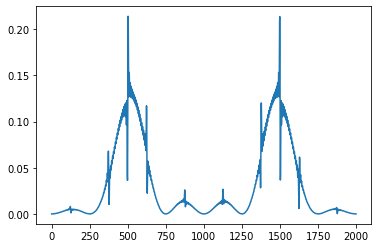

In [52]:
plt.plot(ret[3, 6, 0:int(len(test_f)/2)])

In [13]:
ret[2, :, 0:int(len(test_f)/2)].mean()

0.03133572807548292

In [14]:
ret[3, 6, 0:int(len(test_f)/2)][750]

0.12500000000000375

In [9]:
ret[2, :, 0:int(len(test_f)/2)].min()

1.4985908944240822e-10